In [1]:
from root import *

### Temperature VS Trip Duration

**Analizando el DataFrame de Weather:**

In [2]:
dfWeather.head(3)

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107


In [3]:
dfWeather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [4]:
dfWeather[dfWeather.date == pd.to_datetime('2013-08-29', format='%Y-%m-%d')][['date', 'zip_code']]

,date,zip_code
0,2013-08-29,94107
184,2013-08-29,94063
368,2013-08-29,94301
552,2013-08-29,94041
736,2013-08-29,95113


**Observamos que para cada fecha tenemos pronósticos de 5 zipcodes distintos:**  
Investigando, los zipcodes se corresponden de la siguiente manera

+ 94107 --> San Francisco
+ 94063 --> Redwood City
+ 94301 --> Palo Alto
+ 94041 --> Mountain View
+ 95113 --> San Jose

**Mientras que los zipcodes de la tabla Trips son de los usuarios que usan las bicis:**

In [5]:
print dfTrip.zip_code.unique()
print "Zip Codes distintos:", dfTrip.zip_code.unique().size

['94127' '95138' '97214' ..., '2400105' '1004004' '29609']
Zip Codes distintos: 7440


Por ejemplo:

+ 94127   --> San Francisco
+ 95138   --> San Jose
+ 97214   --> Portland
+ 2400105 --> Japon
+ 29609   --> Greenville

*Estos zip codes en principio no nos servirían para nada más que para saber de donde es la persona que realizó el viaje*

**Las ciudades en las que se encuentran las estaciones son las mismas de las que tenemos información meteorológica:**  
Esto implica que podremos vincular el dato de la duración de un viaje en particular por su start_station_id con una estación en la tabla de stations y así con una ciudad y su información meteorológica.

In [6]:
dfStation.city.unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

### Ploteando :
Voy a necesitar una tabla con estos datos:

| Trip_date     | Duration      | min_temp  | max_temp
|:-------------:|:-------------:|:---------:|:--------:
| XXXX-XX-XX    | xxx           | xx °F     | xx °F

Donde Duration va a ser la media/mediana o el promedio de los viajes en ese dia.
Podria hacer un multiplot para los 5 zipcodes

In [7]:
dfTrip_N_Weather = dfTrip[['duration', 'start_date', 'start_station_id']]
dfTrip_N_Weather.rename(columns={'start_station_id':'id'}, inplace=True)
dfTrip_N_Weather = dfTrip_N_Weather.merge(dfStation[['id', 'city']], on=['id'])
dfTrip_N_Weather = dfTrip_N_Weather[(60*2 <= dfTrip_N_Weather.duration) & (dfTrip_N_Weather.duration <= 3600*9)]
dfTrip_N_Weather.sort_values(by='duration')
dfTrip_N_Weather['zip_code'] = dfTrip_N_Weather.apply(cityNameToZipCode, axis=1)
dfTrip_N_Weather.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,duration,start_date,id,city,zip_code
3,168,2013-08-29 21:43:00,66,San Francisco,94107
4,228,2013-08-29 17:05:00,66,San Francisco,94107
5,237,2013-08-29 13:58:00,66,San Francisco,94107
6,242,2013-08-29 13:58:00,66,San Francisco,94107
7,262,2013-08-29 14:17:00,66,San Francisco,94107


In [8]:
dfTrip_N_Weather.start_date = pd.to_datetime(dfTrip_N_Weather.start_date.dt.date)

In [9]:
dfTrip_N_Weather.rename(columns={'start_date':'date'}, inplace=True)
dfTrip_N_Weather = dfTrip_N_Weather[['duration', 'date', 'city', 'zip_code']].groupby(by=['date', 'city', 'zip_code'])\
                                                          .agg('mean')\
                                                          .reset_index()

# Como el zip code tiene type int64, lo paso a str para poder hacer el merge
# dfTrip_N_Weather.zip_code = int(dfTrip_N_Weather.zip_code)

In [10]:
# Convierto a int64 para poder hacer el merge
dfTrip_N_Weather.zip_code = pd.to_numeric(dfTrip_N_Weather.zip_code)

In [11]:
dfTrip_N_Weather = dfTrip_N_Weather.merge(dfWeather[['date', 'zip_code', 'max_temperature_f', 'min_temperature_f']], on=['date', 'zip_code'])

In [12]:
dfTrip_N_Weather.sort_values(by='duration').head()

,date,city,zip_code,duration,max_temperature_f,min_temperature_f
2831,2015-04-05,Redwood City,94063,131.0,59.0,46.0
3261,2015-07-03,Redwood City,94063,132.0,80.0,62.0
2961,2015-05-02,Redwood City,94063,142.0,69.0,55.0
2343,2014-12-24,Redwood City,94063,165.0,59.0,48.0
2218,2014-11-27,Redwood City,94063,173.0,64.0,46.0


In [13]:
def makeNewDataFrameWithCity(df, city) :
    
    dic = {'date':[], 'city':[], 'zip_code':[], 'duration':[], 'max_temp_f':[], 'min_temp_f':[]}
    
    for i in range(0, len(df)):        
        if (df.iloc[i]['city'] == city ) : 
            dic['date'].append(df.iloc[i]['date'])
            dic['city'].append(df.iloc[i]['city'])
            dic['zip_code'].append(df.iloc[i]['zip_code'])
            dic['duration'].append(df.iloc[i]['duration'])
            dic['max_temp_f'].append(df.iloc[i]['max_temperature_f'])
            dic['min_temp_f'].append(df.iloc[i]['min_temperature_f'])
    
    return pd.DataFrame.from_dict(data=dic, orient='columns')

In [14]:
# Armo 5 DataFrames para poder plotear cada ciudad por separado
dfRedwood = makeNewDataFrameWithCity(dfTrip_N_Weather, 'Redwood City')
dfSanFrancisco = makeNewDataFrameWithCity(dfTrip_N_Weather, 'San Francisco')
dfSanJose = makeNewDataFrameWithCity(dfTrip_N_Weather, 'San Jose')
dfMountainView = makeNewDataFrameWithCity(dfTrip_N_Weather, 'Mountain View')
dfPaloAlto = makeNewDataFrameWithCity(dfTrip_N_Weather, 'Palo Alto')
print len(dfRedwood), len(dfSanFrancisco), len(dfSanJose), len(dfMountainView), len(dfPaloAlto)

643 733 733 725 719


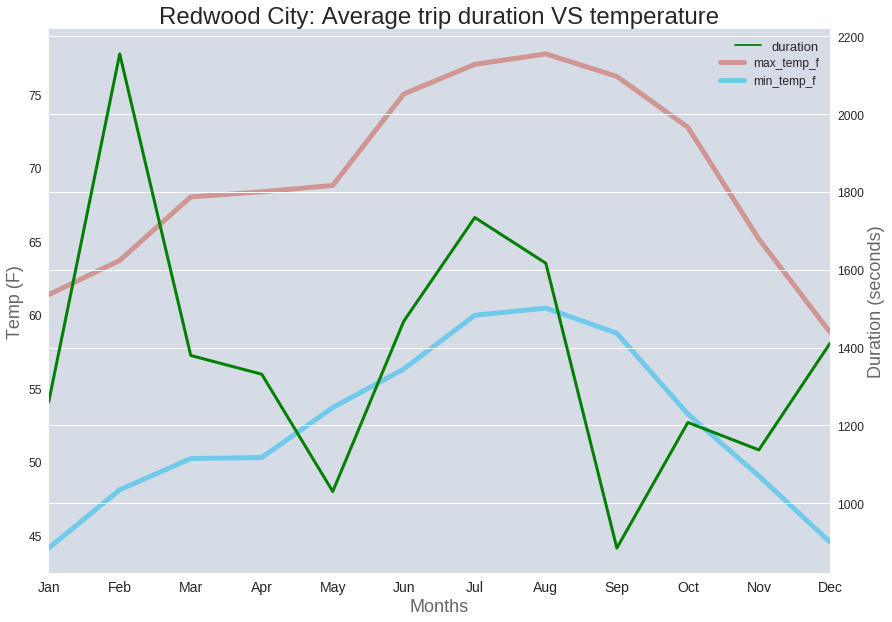

In [15]:
#Redwood
dfRedwood.date = dfRedwood.date.dt.month
dfRedwood = dfRedwood[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfRedwood.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('Redwood City: Average trip duration VS temperature', fontsize=24)
plt.show()

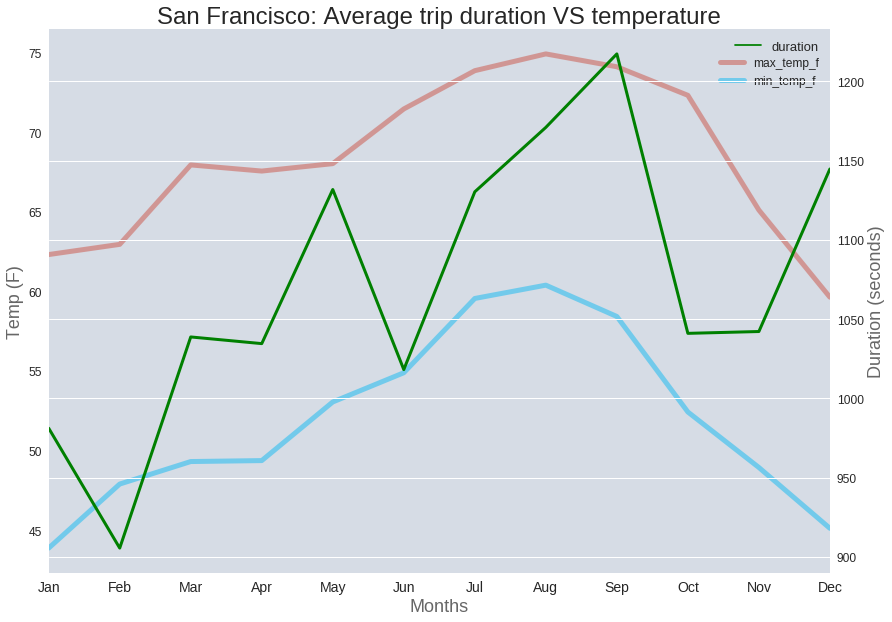

In [18]:
#San Francisco
dfSanFrancisco.date = dfSanFrancisco.date.dt.month
dfSanFrancisco = dfSanFrancisco[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfSanFrancisco.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('San Francisco: Average trip duration VS temperature', fontsize=24)
plt.show()

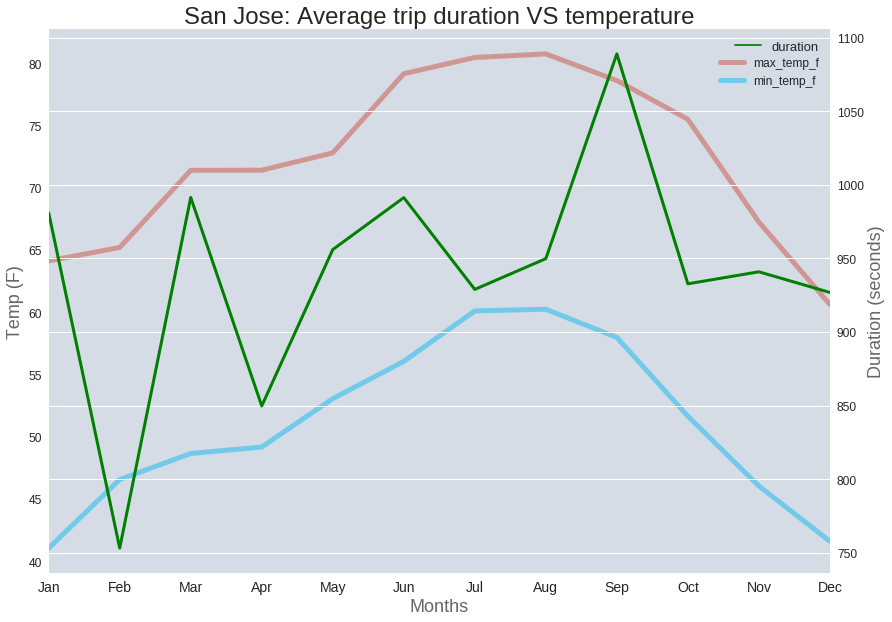

In [19]:
#San Jose
dfSanJose.date = dfSanJose.date.dt.month
dfSanJose = dfSanJose[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfSanJose.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('San Jose: Average trip duration VS temperature', fontsize=24)
plt.show()

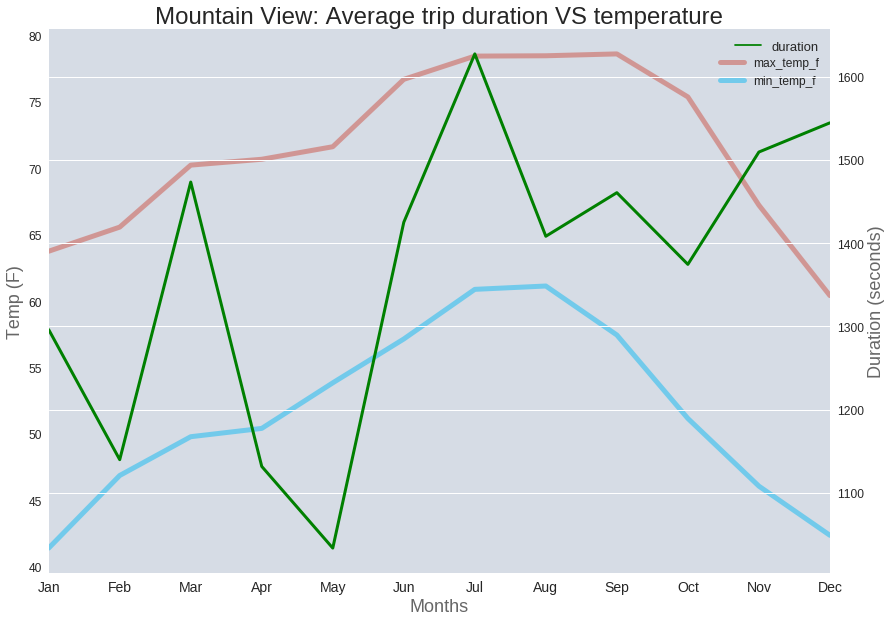

In [20]:
# Mountain View
dfMountainView.date = dfMountainView.date.dt.month
dfMountainView = dfMountainView[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfMountainView.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('Mountain View: Average trip duration VS temperature', fontsize=24)
plt.show()

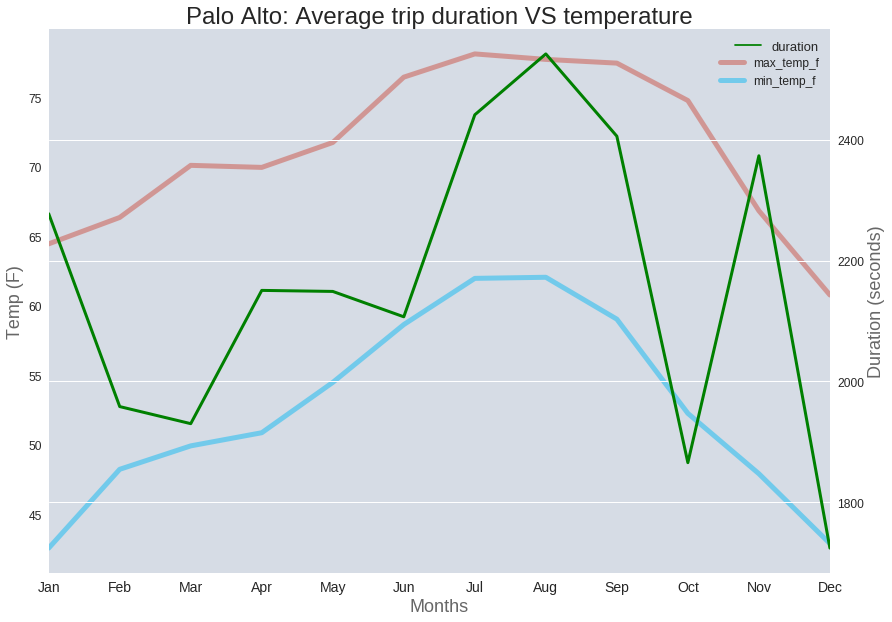

In [21]:
# Palo Alto
dfPaloAlto.date = dfPaloAlto.date.dt.month
dfPaloAlto = dfPaloAlto[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfPaloAlto.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('Palo Alto: Average trip duration VS temperature', fontsize=24)
plt.show()